## Defining our verifier

First, let's define what our criteria for correctness is. In this case, it's quite easy. If the response adheres to the word count upper bound, as in reasonably under the limit, it is "correct".

In [1]:
# Here, we are going with a Programmatic Verification approach since this makes most sense for the use case!
def meets_word_count(s: str, max_words: int, tolerance: float = 0.85) -> tuple[bool, int]:
    """
    Returns whether or not the string `s` meets the word count requirement, with a given tolerance.

    It also returns the delta from the max word count.

    Args:
        s (str): The input string to check.
        max_words (int): The maximum allowed word count.
        tolerance (float): The tolerance level (between 0 and 1) for the word count. Defaults to 0.85.
    """
    words = s.split()
    return len(words) <= max_words and len(words) >= int(max_words * tolerance), max_words - len(words)

# Always test your code!
print(meets_word_count("This is a test string.", 5)) # True, 0
print(meets_word_count("This is a test string.", 4)) # False, -1
print(meets_word_count("This", 5)) # False, 4

(True, 0)
(False, -1)
(False, 4)


## The Resume
Here, we'll load in a single sample resume for demo purposes. In practice, you're application be working with many instances of these. 

In [2]:
with open("data/toy_problem_1/job_resume.txt", "r") as f:
    resume = f.read()

print(resume)

John Doe
Email: johndoe@uwaterloo.ca | Phone: (555) 123-4567 | GitHub: github.com/johndoe | LinkedIn: linkedin.com/in/johndoe
Education: Candidate for BCS, Honours Computer Science, University of Waterloo (Class of 2026)
GPA: 3.7/4.0

---

Technical Skills
- Languages: Python, Java, C++, JavaScript/TypeScript, SQL
- Frameworks & Tools: React, Node.js, Express, Flask, Docker, Git, Linux, AWS (EC2, S3)
- Interests: Full-stack development, distributed systems, cloud infrastructure, and AI/ML applications

---

Work Experience

Software Engineering Intern – Shopify, Ottawa, ON
May 2024 – August 2024
- Contributed to the checkout optimization team, improving load times by ~18% by rewriting key backend endpoints in Go.
- Implemented monitoring dashboards using Grafana + Prometheus, allowing the team to detect and respond to incidents 30% faster.
- Collaborated with product managers and designers to ship A/B tested features that increased conversion rates for merchants.

Backend Developer Co-

## The Job Application
We'll do the same with a sample job application.

In [3]:
# Load in the questions
import json

with open("data/toy_problem_1/job_application_questions.jsonl", "r") as f:
    questions = [json.loads(line) for line in f.readlines()]

# print the job application questions in a nicely formatted manner
for idx, question in enumerate(questions):
    print(f"{idx + 1}) {question['question']} Max word count: {question['max_word_count']}")

1) Why are you interested in working at our company, and how does our mission align with your career goals? Max word count: 300
2) Describe a technical project you’ve worked on that you are most proud of. What was your role and what impact did it have? Max word count: 250
3) Tell us about a time you faced a significant coding or technical challenge. How did you approach solving it? Max word count: 500
4) How do you stay up-to-date with the latest tools, frameworks, and technologies in software engineering? Max word count: 150
5) Explain a situation where you had to collaborate with teammates (engineers, designers, or PMs) to deliver a project. What did you learn from the experience? Max word count: 1000
6) What motivates you to perform at your best, and how do you sustain that motivation during long or complex projects? Max word count: 300
7) Share an example of when you had to quickly learn a new technology, tool, or framework to complete a project. How did you approach it? Max word c

## Build the Prompts
Remember that LLMs always work with prompts and are mostly trained to act as assistants. Here, we'll create a basic function which fills a **prompt template** which we can saturate with any arbitrary resume, job application question, and word count limit. 

In practice, you may need to iterate a bit on the prompt, but less so nowadays as LLMs are becoming more robust.

In [4]:
def build_prompt(resume: str, question: str, max_word_count: int) -> str:

    prompt = f"""You are an expert job application writer. You have been given the following resume:
<resume>
{resume}
</resume>

Please answer the following question based on the resume provided. 

Your answer must be no more than **{max_word_count}** words, but the length should also not fall too far below this limit (at least 85% of the max word count).

Question: {question}

Please provide JUST the response to the question without any additional commentary.

Response:"""

    return prompt

# Always test your code!
TEST_RESUME = "Eugene Cho. OSSD"
TEST_QUESTION = "Why do you want to work at Cohere?"
TEST_MAX_WORD_COUNT = 100
print(build_prompt(TEST_RESUME, TEST_QUESTION, TEST_MAX_WORD_COUNT))

You are an expert job application writer. You have been given the following resume:
<resume>
Eugene Cho. OSSD
</resume>

Please answer the following question based on the resume provided. 

Your answer must be no more than **100** words, but the length should also not fall too far below this limit (at least 85% of the max word count).

Question: Why do you want to work at Cohere?

Please provide JUST the response to the question without any additional commentary.

Response:


## Baseline
We need to establish our baseline before trying anything fancy. Otherwise how will we know if our setup is working or is any good?

Here, our baseline is if we just generate 1 response from the LLM for each question. Let's see how many pass the application. Remember: pass == meets word count criteria.

In [5]:
from utils.model_utils import single_chat_n_times
import copy 
import random

def run_validation(question: dict, outputs: list[dict]):
    """
    Run validation on the outputs for a given question. Updates the question dict in place. 

    Args:
        question (dict): The question dict containing the question and max_word_count.
        outputs (list[dict]): The list of outputs from the model.
    """
    
    for o in outputs:
        if o["ok"]:
            response = o['response'].message.content[-1].text

            # Determine whether or not response was "correct"
            o["is_correct"], o["wc_delta"] = meets_word_count(response, question["max_word_count"]) 
  
        else:
            print(f"FAILED TO GET RESPONSE: {o['error']}")
            o["is_correct"] = False
            o["wc_delta"] = None
    
    question["outputs"] = outputs


def run_generation(
        resume: str, 
        questions: list[dict], 
        num_responses, 
        model: str = "command-a-03-2025", 
        temp: float = 1.0, 
        p: float = 1.0,
        max_workers: int | None = None) -> None:
    """
    Run generation for a list of questions and update the questions in place with the outputs.
    
    Args:
        resume (str): The resume to use for the prompts.
        questions (list[dict]): The list of question dicts.
        num_responses (int): The number of responses to sample from the model for each question.
        model (str): The model to use for generation. Defaults to "command-a-03-2025".
        temp (float): The temperature to use for generation. Defaults to 1.0.
        p (float): The nucleus sampling parameter to use for generation. Defaults to 1.0.
    """
    # For every question
    for question in questions:

        # build the prompt
        prompt = build_prompt(resume, question["question"], question["max_word_count"])
        
        # always store your prompt for easy debugging!
        question["prompt"] = prompt

        # sample from the model num_responses times
        outputs = single_chat_n_times(
            n=num_responses,
            model=model,
            messages=[{"role": "user", "content": prompt}],
            temperature=temp,
            p=p,
            max_workers=max_workers
        )

        # shuffle the outputs to avoid any ordering bias from the api
        random.shuffle(outputs) 

        run_validation(question, outputs)

baseline_questions = copy.deepcopy(questions)
run_generation(resume, baseline_questions, 1)

Now let's compute the passrate.

In [6]:
def compute_pass_rate(questions: list[dict], num_responses: int):
    """
    Computes the pass rate for the given questions based on the correctness of the responses.
    Mutates each question dictionary to include a new key "correctness_best_of_{num_responses}" which contains:
        - "correct_responses": A list of tuples of (response text, wc_delta) for all correct responses
        - "best_response": The best response (response text, wc_delta) among the correct responses, or None if there are no correct responses
        - "passes": A boolean indicating whether at least one correct response was found
    
    Args:        
        questions (list[dict]): A list of question dictionaries, each containing an "outputs" key
        num_responses (int): The number of responses to consider for each question. This should be less than or equal to the length of the "outputs" list in each question.         
    """
    # For each question
    for question in questions:

        correctness_data_obj = {"correct_responses": [], "best_response": None, "passes": False}

        assert num_responses <= len(question["outputs"]), f"num_responses {num_responses} is greater than number of outputs {len(question['outputs'])}"
        
        # For each output
        for idx, output in enumerate(question["outputs"]):

            # Only consider up to the first num_responses outputs
            if idx + 1 > num_responses:
                break
            
            # If the response is correct
            if output["is_correct"]:
                correctness_data_obj["correct_responses"].append((output['response'].message.content[-1].text, output["wc_delta"]))
                correctness_data_obj["passes"] = True

        if len(correctness_data_obj["correct_responses"]) > 0:
            # Our criteria for the "best" response is the one that is closest to the max word count (i.e. has the smallest wc_delta)
            # because of our previously stated assumption that the longer the response, the better!
            correctness_data_obj["best_response"] = sorted(correctness_data_obj["correct_responses"], key=lambda x: x[1], reverse=False)[0]

        question[f"correctness_best_of_{num_responses}"] = correctness_data_obj

compute_pass_rate(baseline_questions, 1)
pass_rate = len([q for q in baseline_questions if q["correctness_best_of_1"]["passes"]]) / len(baseline_questions)
pass_rate

0.2

aka our baseline sucks

## Test-Time Scaling Approach
So it looks like our passrate is quite mid for our baseline. What happens if we **scale** the number of responses we give the model prompt question? (i.e. what if we **scale** test time compute?)

In [7]:

num_responses = 64
ttc_questions = copy.deepcopy(questions)
run_generation(resume, ttc_questions, num_responses)

stats = []

for n in range(0, 7):
    
    num_responses = 2**n
    compute_pass_rate(ttc_questions, num_responses)
    pass_rate = len([q for q in ttc_questions if q[f"correctness_best_of_{num_responses}"]["passes"]]) / len(ttc_questions)

    stats.append((num_responses, pass_rate))


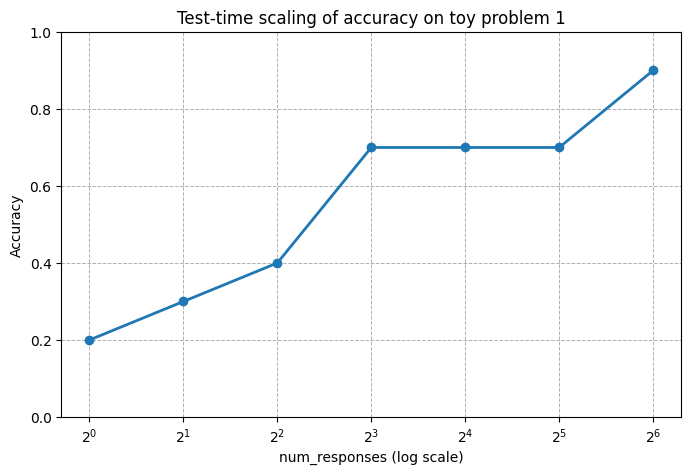

In [8]:
import matplotlib.pyplot as plt

def plot_log_line(data, y_label, x_label, title, normalize=True):
    """
    Plots a line graph with x-axis on log scale.
    
    Parameters:
        data (list of tuples): Each tuple contains (x, y), 
                               where x is a power of 2 and y is between 0 and 1.
    """
    # Unpack the tuples into x and y lists
    x, y = zip(*data)

    plt.figure(figsize=(8, 5))
    plt.plot(x, y, marker="o", linestyle="-", linewidth=2)

    # Set log scale for x-axis
    plt.xscale("log", base=2)

    # Labels and title
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.grid(True, which="both", linestyle="--", linewidth=0.7)

    if normalize:
        plt.ylim(0, 1)
    plt.show()

plot_log_line(stats, "Accuracy", "num_responses (log scale)", "Test-time scaling of accuracy on toy problem 1")


We see a clear upward trend in accuracy as we scale by an exponent of 2, the number of responses (or number of chances) that we give the model at the problem! 

**Note, this is a small sample size. Once again, it is ideal if your eval is as large and diverse as possible for better signal.

Unfortunately, in this scenario if we continue scaling the exponent, we won't continue seeing a trend upwards, as it plateaus around 64 responses.

For some problem domains, the magical number where the scaling plateaus will differ. This magical number is for you to discover through experimentation!

# Compute Spend
An obvious by-product of scaling test-time compute is that you are spending more $$$! D:

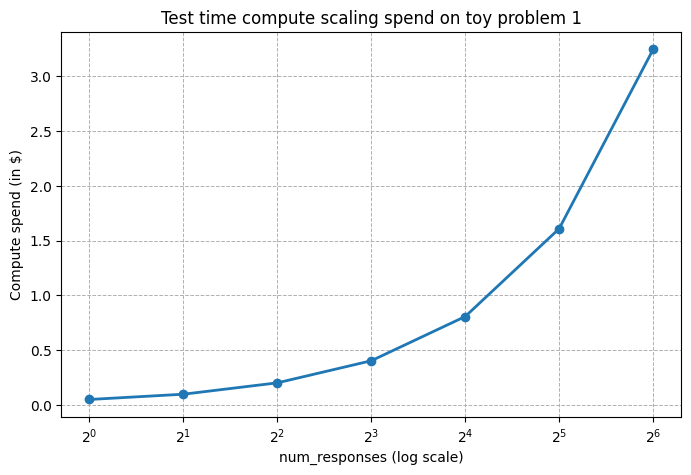

In [9]:
PRICE_PER_INPUT_TOKEN = 2.50 / 1e6 # $2.50 per 1 million input tokens
PRICE_PER_OUTPUT_TOKEN = 10.00 / 1e6 # $10.00 per 1 million output tokens

def compute_total_compute_spend(questions: list[dict], num_responses: int) -> float:
    """
    Computes the total compute spend for the given questions questions up to num_responses.
   
    Args:        
        questions (list[dict]): A list of question dictionaries, each containing an "outputs" key
        num_responses (int): The number of responses to consider for each question. This should be less than or equal to the length of the "outputs" list in each question.         
    """
    total_compute_spend = 0
    
    # For each question
    for question in questions:

        # For each output
        for idx, output in enumerate(question["outputs"]):

            if idx + 1 > num_responses:
                break
            
            input_tokens = output['response'].usage.billed_units.input_tokens
            output_tokens = output['response'].usage.billed_units.output_tokens

            total_compute_spend += input_tokens * PRICE_PER_INPUT_TOKEN + output_tokens * PRICE_PER_OUTPUT_TOKEN

    return total_compute_spend

spending_stats = []

for n in range(0, 7):
    num_responses = 2**n
    total_compute_spend = compute_total_compute_spend(ttc_questions, num_responses)
    spending_stats.append((num_responses, total_compute_spend))

plot_log_line(spending_stats, "Compute spend (in $)", "num_responses (log scale)", "Test time compute scaling spend on toy problem 1", normalize=False)


Obviously, our compute spend scales exponentially as we scale the number of responses exponentially. This is the main tradeoff of scaling test-time compute: accuracy gains are not free!

It is up to the implementer to determine what level of accuracy is acceptable for a given compute budget.

# Bonus
What if we scale test-time compute 2-dimensionally? Let's try using `command-a-reasoning-08-2025`!

In [ ]:
num_responses = 32
reasoning_ttc_questions = copy.deepcopy(questions)
run_generation(resume, reasoning_ttc_questions, num_responses, "command-a-reasoning-08-2025", max_workers=16)

stats = []

for n in range(0, 6):
    
    num_responses = 2**n
    compute_pass_rate(reasoning_ttc_questions, num_responses)
    pass_rate = len([q for q in reasoning_ttc_questions if q[f"correctness_best_of_{num_responses}"]["passes"]]) / len(reasoning_ttc_questions)

    stats.append((num_responses, pass_rate))


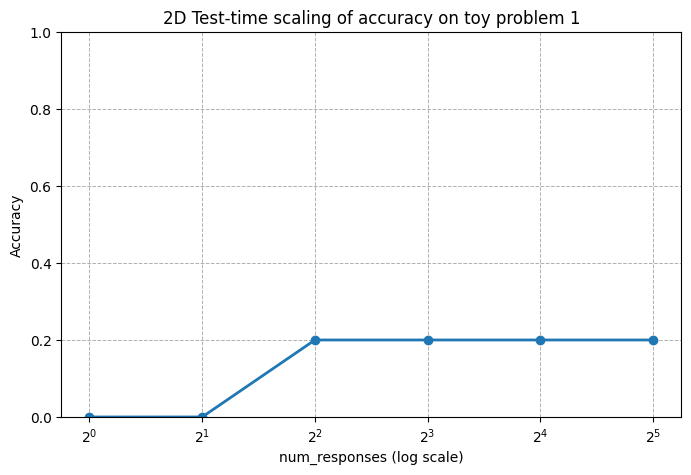

In [ ]:
plot_log_line(stats, "Accuracy", "num_responses (log scale)", "2D Test-time scaling of accuracy on toy problem 1")
